## Bayes Ingenuo:  
### Raul Marusca  
#### 2021

Como siempre, cargamos primero las librerias que vamos a usar y configuramos algunas cosas utiles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 

from sklearn.naive_bayes import GaussianNB 
# se pueden probar otros, por ej. MultinomialNB.
# La lista completa está acá: https://scikit-learn.org/stable/modules/naive_bayes.html

# Vamos a hacer alguna que otra matriz de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

#import seaborn as sns

# Limitamos el tamaño de los graficos
plt.rcParams["figure.figsize"] = (20,10)

Ahora leemos el dataset y los nombres de los campos/variables

In [2]:
# Cargamos el dataset
datos = np.loadtxt('./salud_fetal.csv',delimiter=',')

# Los nombres de las columnas viene en otro .csv como info de una columna
# los cargamos de ahi y los cnvertimos a lista
nombres = np.genfromtxt('./salud_fetos_variables - Sheet1.csv',
                         delimiter=',',
                         usecols = (1), 
                         skip_header=True, 
                         dtype=str).tolist()
#print(columnas)

## Con dos clases
Ya cargadas las librerias necesarias y el dataset iniciaremos un analisis de los datos reduciendo el numero de clases originales a dos.  
Inicialmente tenemos una clasificacion que reporta 1=normal, 2=sospechoso, 3=patológico y a partir de una manipulacion nos quedaremos con una clasificacion en 1=normal, 2=sospechoso/patológico

In [3]:
# extraigo variables (predictoras, features, características, son todos nombres que se usan)
X = datos[:,0:-1]
# print(X.shape)
# print(X[0:5,:])

# extraigo clasificación (target, labels, etiquetas, son todos nombres que se usan)
y = datos[:,-1]
# print(y.shape)
# print(y[0:5])


# Escalo los datos: en general es buena idea para que el algoritmo funcione mejor
scaler = StandardScaler()
scaler.fit(X) #calcula promedio y desvío
X = scaler.transform(X) #estandariza con promedio y desvío antes calculado

# Como el target tiene tres valores posibles, vamos a realizar una conversion a solo dos casos
# reemplazamos todos los 3 por 2
# recordemos que 1=normal,2=sospechoso, 3=patológico
# lo hacemos por list comprehension
y_2 = np.array([2 if y[i] >= 2 else 1 for i in range(len(y))])

#print(y_2)

Para una mejor visualizacion d elos datos vamos a aplicar una reduccion de dimensiones por Componentes Principales y analizaremos cuanta informacion obtendremos seleccionando los dos primeros PCA con mayor varianza

In [4]:
# Vamos a probar con PCA
# Creamos el objeto que aloja los metodos para transformar a Componentes Principales
pca = PCA()

# Ajustamos ese modelo a nuestras features y target
pca.fit(X,y_2)

# Aplicamos ese modelo ajustado a nuestras features y obtenemos la prediccion del target 
x_new = pca.transform(X)

In [5]:
# Varianza explicada por cada componente
var_pc = pca.explained_variance_ratio_
#print(var_pc)

# Recorremos var_pc y mostramos su contribucion a la varianza
indice = 1
for var in var_pc:
    print("PCA{:2} : {:6.4f}".format(indice, round(var,4)))
    indice += 1

PCA 1 : 0.2885
PCA 2 : 0.1670
PCA 3 : 0.0869
PCA 4 : 0.0713
PCA 5 : 0.0580
PCA 6 : 0.0486
PCA 7 : 0.0468
PCA 8 : 0.0441
PCA 9 : 0.0363
PCA10 : 0.0305
PCA11 : 0.0275
PCA12 : 0.0237
PCA13 : 0.0185
PCA14 : 0.0156
PCA15 : 0.0126
PCA16 : 0.0086
PCA17 : 0.0063
PCA18 : 0.0056
PCA19 : 0.0024
PCA20 : 0.0013
PCA21 : 0.0000


 Podemos ver que con las dos primeras PCA se pueden explicar aproximadamente el 35% de los datos

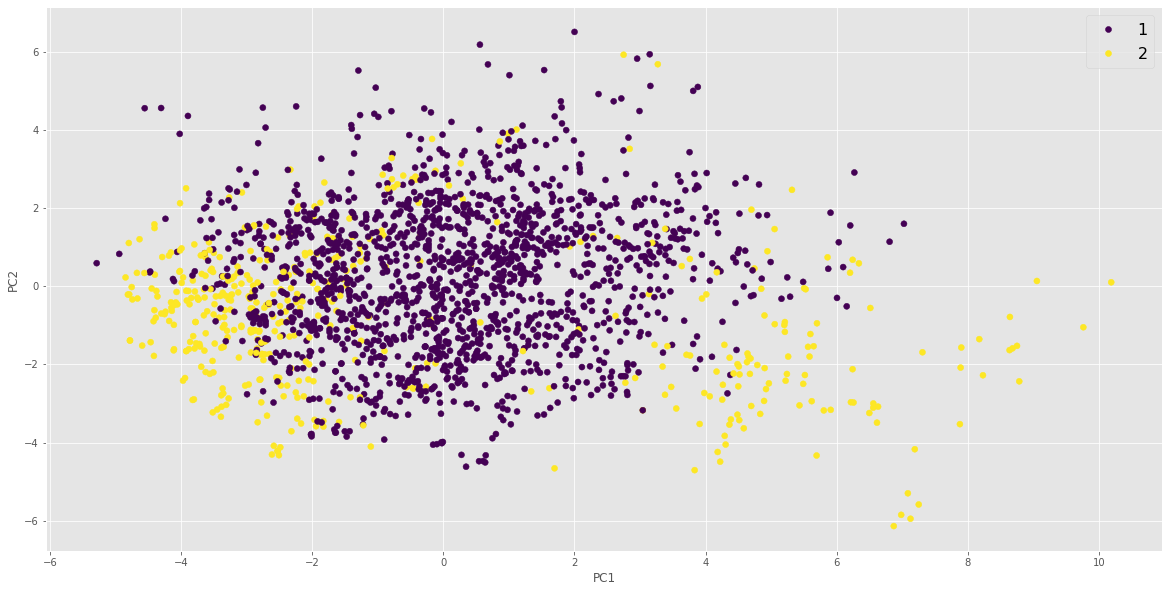

In [6]:
# le damos un estilo a nuestro grafico
plt.style.use('ggplot')

# asignamos los dos primeros PC a los ejes coordinados
x_valor = x_new[:,0]
y_valor = x_new[:,1]

# hacemos un grafico de dispersion
dispersion_1 = plt.scatter(x_valor, y_valor , c=y_2)

# Le ponemos nombre a los ejes
plt.xlabel("PC1");
plt.ylabel("PC2");

# mostramos la leyend
plt.legend(handles=dispersion_1.legend_elements()[0], labels=dispersion_1.legend_elements()[1], fontsize=16)

# Mostamos la grilla
#plt.grid();

# imprimimos el grafico completo
plt.show();

Con bastante imaginacion podemos ver un cluster central con mayoria de casos favorables rodeado por dos clusters de casos sospechos/patologicos

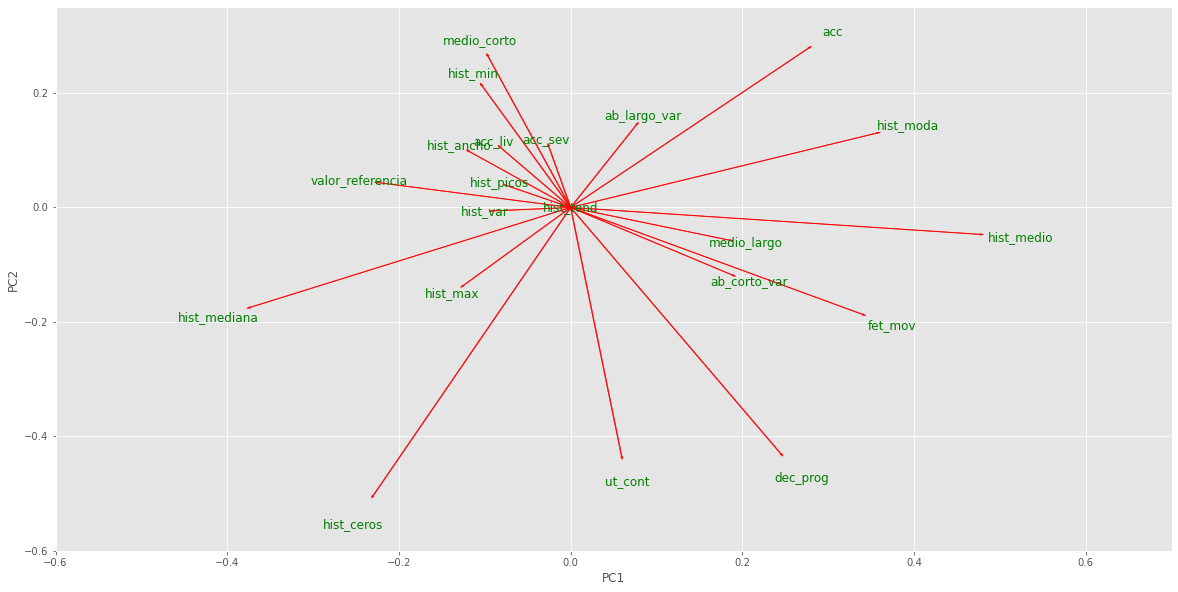

In [7]:
# Definimos el rango de los ejes del grafico
plt.axis([-0.6,0.70,-0.6,0.35])

# Vemos cuantos vectores son las direcciones de maxima varianza
n = pca.components_.shape[0]

# Recorremos esos vectores y los vamos dibujando en el plano
for i in range(n):
    plt.arrow(0, 0, pca.components_[i,0], pca.components_[i,1], color = 'r', alpha = 1);
    # En el extremo de cada vector ponemos en nombre de la columan correspondiente (un poco dezplazados)
    plt.text(pca.components_[i,0]*1.1 , pca.components_[i,1]*1.1, nombres[i], color = 'g', ha = 'center', va = 'center', fontsize=12);

# Le ponemos nombre a los ejes
plt.xlabel("PC1");
plt.ylabel("PC2");

# imprimimos el grafico completo
plt.show();

Las variables originales con mayor proyeccion sobre PCA1 son *hist_mediana* y *hist_medio*  
Sobre PCA2 podemos decir que las mas influyentes son *hist_ceros*, *ut_cont* y *dec_prog*

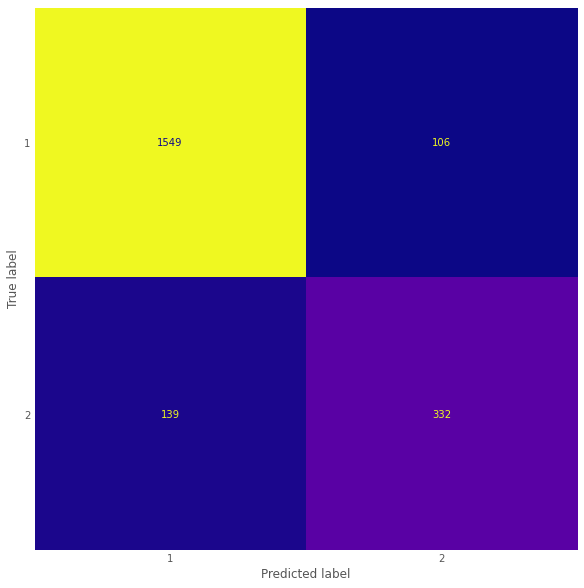

In [8]:
# Analizamos con Bayes Ingenuo
# instanciamos el modelo Bayes ingenuo
gnb = GaussianNB() 

# ajustamos nuestros features y target
modelo_gnb = gnb.fit(X, y_2) 

# Ahora hacemos que prediga con nuestros features
y_2_nb_pred = modelo_gnb.predict(X) 

# matriz de confusión
conf = confusion_matrix(y_2,y_2_nb_pred)

# grafico matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=gnb.classes_)
disp.plot(values_format='d', colorbar=False, cmap='plasma')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)


In [9]:
#probabilidades de cada clase según modelo predictivo
probas = gnb.predict_proba(X) 
#print(probas)
# inspecciono esas probabilidades
#with np.printoptions(precision=3, suppress=True):
#    print(probas[0:20])

# por ejemplo, por defecto asumo que esta sano
y_2_pred_07 = np.ones(y_2_nb_pred.shape)

#y si la probabilidad es mayor a 0.7, lo clasifico como sospechoso/patologico
y_2_pred_07 = np.array([1 if probas[i,0] >= 0.7 else 2 for i in range(len(probas))])

#print(y_2_pred_07)

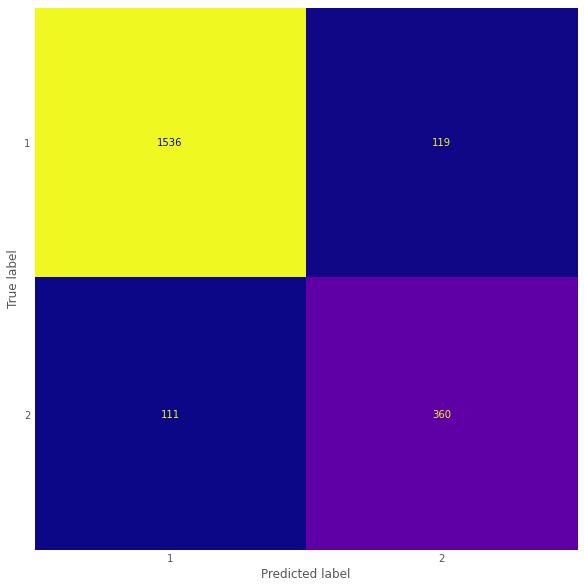

In [10]:
# Ahora vemos como resulta la matriz de confusion con este nuevo limite
conf_07 = confusion_matrix(y_2,y_2_pred_07)

disp_07 = ConfusionMatrixDisplay(confusion_matrix=conf_07, display_labels=gnb.classes_)
disp_07.plot(values_format='d', colorbar=False, cmap='plasma')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None) 


Aumentando el punto de corte del por defecto que es 0.5 a 0.7 podemos ver que reducimos levemente (en el rango de un 20% approximadamente el numero de casos predichos como sanos pero que en realidad eran sospechosos/patologicos.  
Tambien podemos observar que se incrementan los numero de casos predichos correctamente e incorrectamente como sospechosos/patologicos.  
El efecto en la practica clinica seria que aumentaremos aproximadamente un 10% los costos de tratamiento de los casos sospechosos/patologicos mal predichos, pero reduce el numero de casos que necesitarian tratamiento y no se los brindariamos porque el modelo los clasifica como sanos.  
Se ha usado un valor de corte arbitrario (0.7) pero deberiamos consultar con los expertos en el area cual seria el valor correcto mas adecuado a la practica cotidiana de estos estudios.

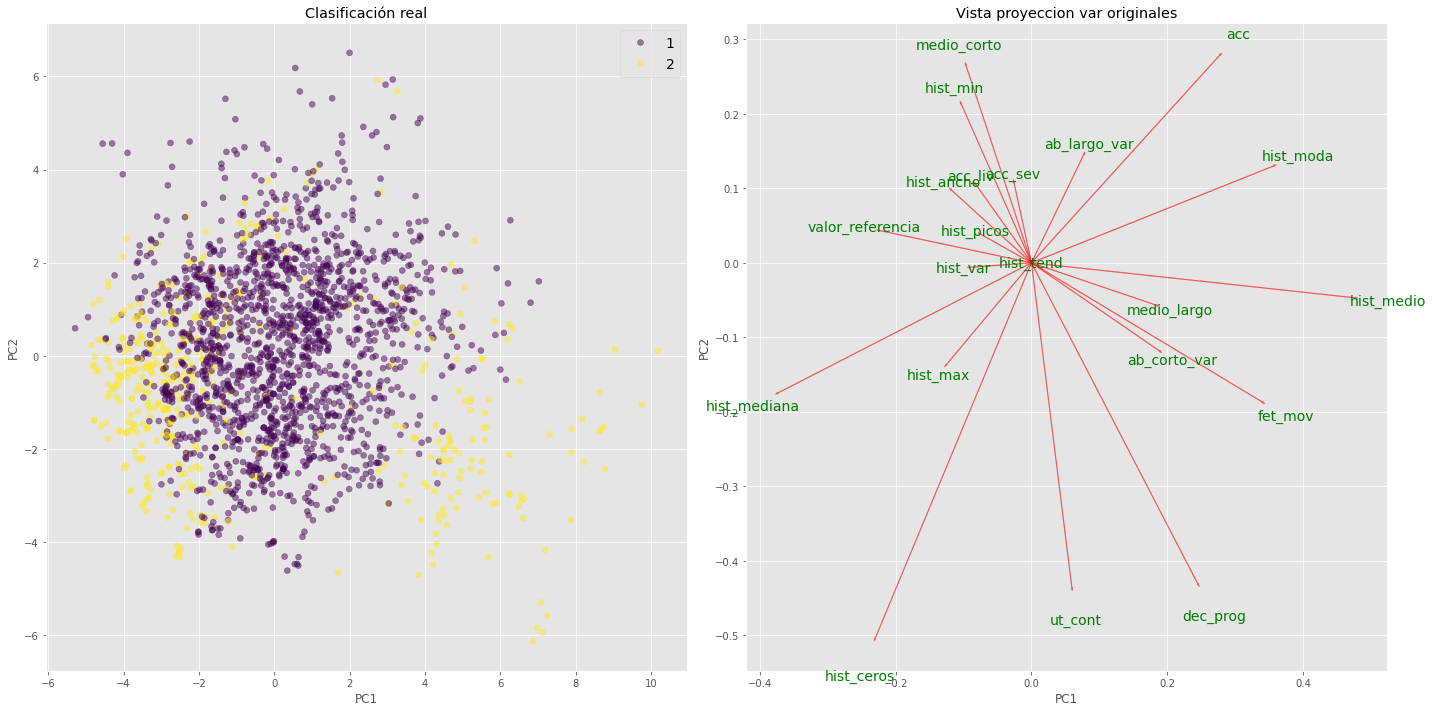

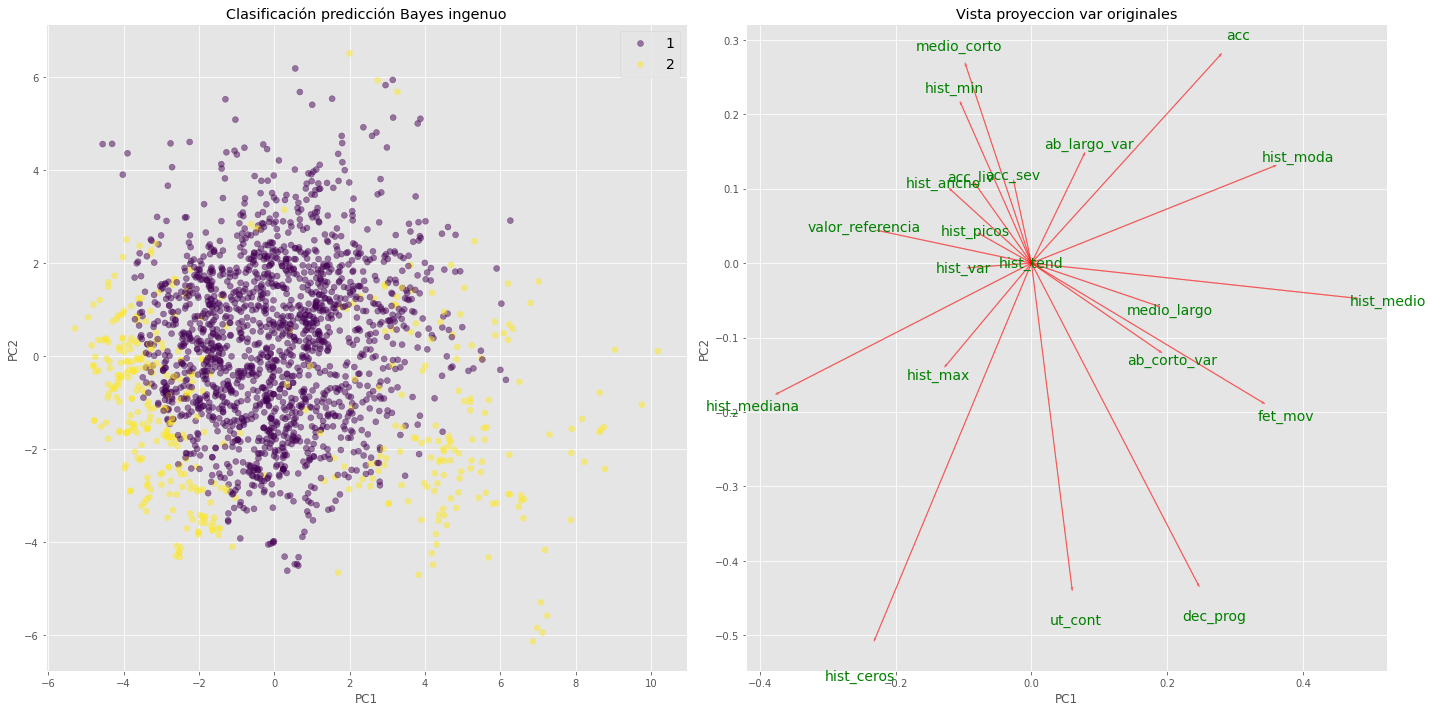

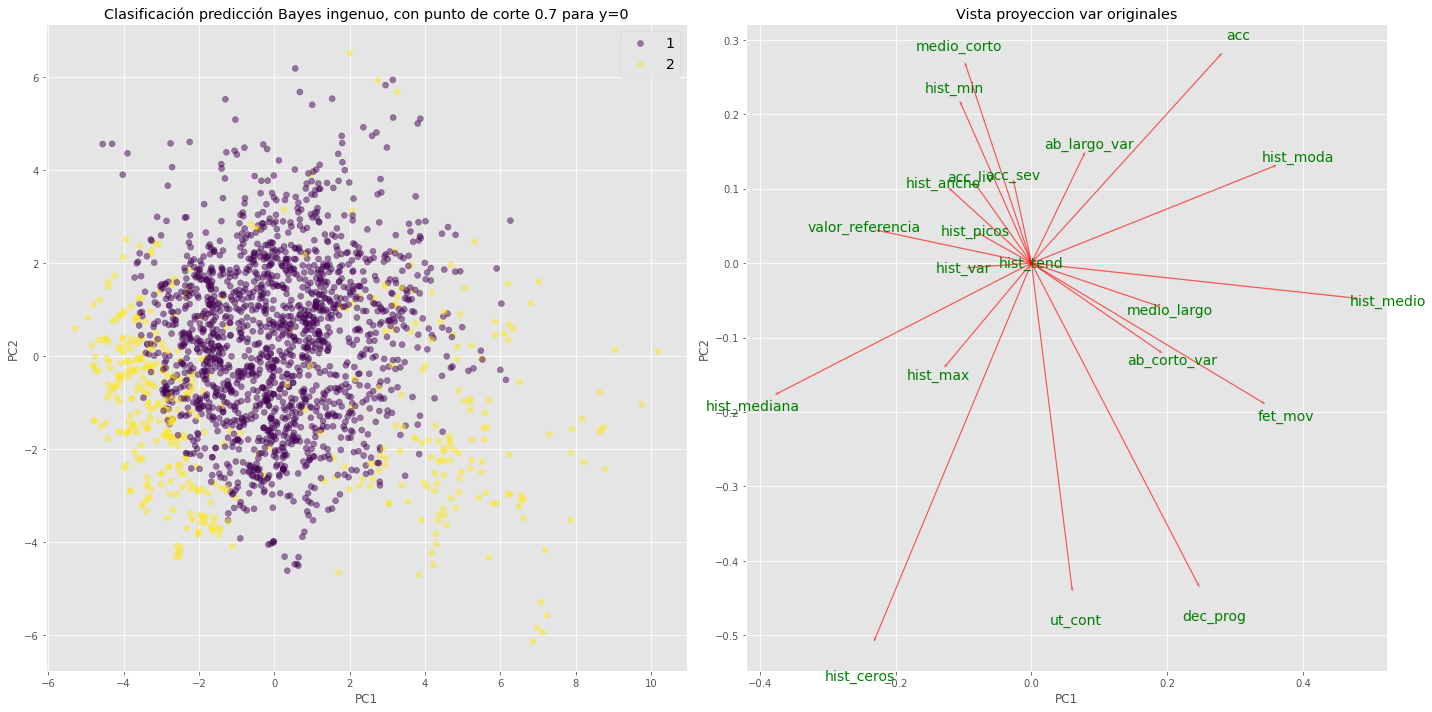

In [11]:
# Y vemos como se compara con los componentes principales
pca = PCA()
pca.fit(X)
x_new = pca.transform(X)


def myplot(score,coeff,clases,labels=None,titulo1='Vista PCA',titulo2='Vista proyeccion var originales'):
    # grafico 1 con el scatterplot
    # creo el primer subplot a la izquierda (Ver doc matplotlib - subplots)
    fig1 = plt.subplot(1, 2, 1)
    # Esto ya estaba
    x1 = score[:,0]
    x2 = score[:,1]
    n = coeff.shape[0]
    # El scatter en si mismo
    scatter = plt.scatter(x1, x2, c=clases, alpha=0.5)
    # El cuadrito con las clases del target
    plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], fontsize=14)
    # Los ejes
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    # La grilla
    #plt.grid()
    # que le ponga el titulo pasado a la funcion
    plt.title(titulo1)
    
    # grafico 2 con la proyeccion
    # creo el segundo subplot a la derecha
    fig2 = plt.subplot(1, 2, 2)
    # Esto sigue igual que al original
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        # si no vienen los nombres de los campos
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center', fontsize=14)
        # si vienen los nombres de los campos
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, labels[i], color = 'g', ha = 'center', va = 'center', fontsize=14)
    # Los ejes
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    # la grilla
    #plt.grid()
    # el titulo del segundo grafico
    plt.title(titulo2)
    # Le doy una separacion para que no se junten los graficos
    plt.tight_layout()
    plt.show()       

#Grafico las primeras dos componentes principales para cada clasificación

#clasificación real
myplot(x_new[:,0:2], pca.components_, y_2, nombres,'Clasificación real')


#clasificación bayes ingenuo
myplot(x_new[:,0:2], pca.components_, y_2_nb_pred, nombres, 'Clasificación predicción Bayes ingenuo')

#clasif. bayes ingenuo con punto de corte 0.7 para y=0
myplot(x_new[:,0:2], pca.components_, y_2_pred_07, nombres, 'Clasificación predicción Bayes ingenuo, con punto de corte 0.7 para y=0')
# plt.xlabel("PC{}".format(1))
# plt.ylabel("PC{}".format(2))
# plt.title("Clasificación predicción Bayes ingenuo, con punto de corte 0.7 para y=0")
# plt.grid()
# plt.show()


En las graficas de PCA podemos ver que se acentua la clasificacion incorrecta de los casos mas alejados del grupo central, pero recordemos que en esta proyeccion solo podemos "ver/explicar" aproximadamente el 35% de los casos. No estamos viendo otras dimensiones.  
Si bien no puedo entenderlo correctamente 

Podemos desde los datos que ya tenemos, crear una funcion que nos de los datos de la matriz de confusion en forma de tabla asi podemos apreciar como afecta el cambio en el valor de corte a la cantidad de aciertos o errores en la prediccion

In [12]:
# Definimos una funcion que calcula los parametros de la matriz de confusion a partir de variar 
# el resultado del array de target
def confusion(valor_corte=0.5):
    y_2_var = np.array([1 if probas[i,0] >= valor_corte else 2 for i in range(len(probas))])
    tp, fn, fp, tn = confusion_matrix(y_2,y_2_var).ravel()
    return(tn, fp, fn, tp)
    
for i in range(0,10,1):
    salida = confusion(i/10)
    print("corte:\t {}\t tn:\t {}\t fp:\t {}\t  fn:\t {}\t  tp:\t {}".format(i/10,
                                                                             salida[0],
                                                                             salida[1],
                                                                             salida[2],
                                                                             salida[3],))
    

corte:	 0.0	 tn:	 0	 fp:	 471	  fn:	 0	  tp:	 1655
corte:	 0.1	 tn:	 282	 fp:	 189	  fn:	 71	  tp:	 1584
corte:	 0.2	 tn:	 299	 fp:	 172	  fn:	 83	  tp:	 1572
corte:	 0.3	 tn:	 315	 fp:	 156	  fn:	 89	  tp:	 1566
corte:	 0.4	 tn:	 324	 fp:	 147	  fn:	 99	  tp:	 1556
corte:	 0.5	 tn:	 332	 fp:	 139	  fn:	 106	  tp:	 1549
corte:	 0.6	 tn:	 342	 fp:	 129	  fn:	 111	  tp:	 1544
corte:	 0.7	 tn:	 360	 fp:	 111	  fn:	 119	  tp:	 1536
corte:	 0.8	 tn:	 371	 fp:	 100	  fn:	 128	  tp:	 1527
corte:	 0.9	 tn:	 381	 fp:	 90	  fn:	 155	  tp:	 1500


## Con tres clases
Repetiremos el mismo analisis pero empleando la clasificacion original del target

In [13]:
# Por las dudas recargo el data set, separo features de target y escalo los features
# Cargamos el dataset
datos = np.loadtxt('./salud_fetal.csv',delimiter=',')

# Los nombres de las columnas viene en otro .csv como info de una columna
# los cargamos de ahi y los convertimos a lista
nombres = np.genfromtxt('./salud_fetos_variables - Sheet1.csv',
                         delimiter=',',
                         usecols = (1), 
                         skip_header=True, 
                         dtype=str).tolist()
#print(columnas)
# extraigo variables (predictoras, features, características, son todos nombres que se usan)
X = datos[:,0:-1]
# print(X.shape)
# print(X[0:5,:])

# extraigo clasificación (target, labels, etiquetas, son todos nombres que se usan)
y = datos[:,-1]
# print(y.shape)
# print(y[0:5])

# Escalo los datos: en general es buena idea para que el algoritmo funcione mejor
scaler = StandardScaler()
#calcula promedio y desvío
scaler.fit(X) 
#estandariza con promedio y desvío antes calculado
X = scaler.transform(X) 

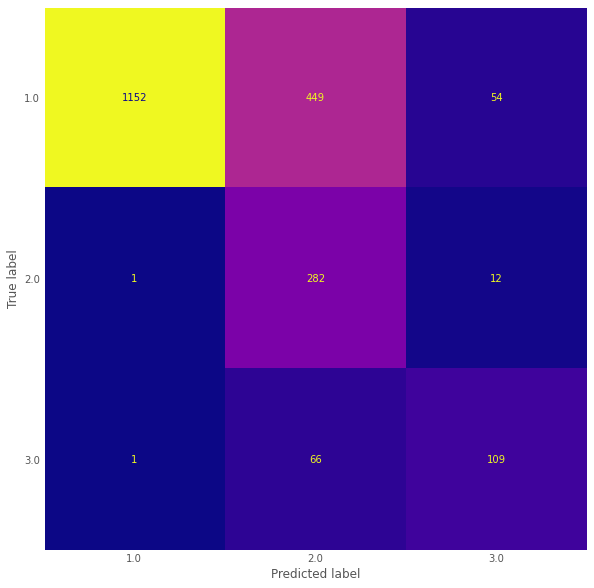

In [14]:
# instancio la clase
gnb_3 = GaussianNB() 
# entreno modelo predictivo a partir de los datos, es decir construyo en borde de decisión
modelo_gnb_3 = gnb_3.fit(X, y) 
# clasifico según modelo. Por defecto clasifica según la clase con probablidad más alta
y_3_pred = modelo_gnb_3.predict(X) 

# matriz de confusión
conf_3 = confusion_matrix(y,y_3_pred)

# plt.rcParams["figure.figsize"] = (15,15)
# grafico matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_3, display_labels=gnb_3.classes_)
disp.plot(values_format='d', colorbar=False, cmap='plasma') 
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

El modelo Bayes Ingenuo cuando el target es multiclass (es decir no es binario, sino que tiene mas de dos posibles estados - en este caso son tres) genera una matriz que contiene el mismo numero columnas que clases.    Cada una de ellas tiene el valor de la probabilidad de pertenecer a esa clase.  


In [15]:
# probabilidades de cada clase según modelo predictivo
probas_3 = gnb_3.predict_proba(X) 
# inspecciono esas probabilidades
# imprimiendo la matriz de probabilidades
with np.printoptions(precision=3, suppress=True):
    print(probas_3[0:20])

[[0.    0.99  0.01 ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.01  0.99  0.   ]
 [0.01  0.99  0.   ]
 [0.007 0.993 0.   ]
 [0.035 0.965 0.   ]
 [0.278 0.722 0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]]


Por defecto asigna la clase predicha eligiendo la de la columna que tiene la mayor probabilidad.  
Asi que si queremos mover ese punto para explorar distintos escenarios no es tan facil como en el caso de tener solo dos clases.  
Como aqui estas trabajando con los datos de posibles condiciones de salud de un feto, deberiamos buscar la forma de reducir la cantidad de prediccion de "normales" (clase 1) cuando no lo son  
Pero ya vemos que con estos datos y la clasificacion por defecto ese numero es muy bajo (1 realmente clasificado como sospechoso y 1 realmente clasificado como patologico)  
Pero tambien vemos que clasifico muchos normales que en realidad son sospechosos y un numero menor que clasifico como patologico siendo en realidad normales.  
Si nuestro interes esta entonces en corregir ese numero de "falsos positivos" para reducir costes de estudios y  tratamientos propongo que se determine como patologico a los casos donde la probabilidad de ser patologico sea claramente superior a la de ser normal (1.4 veces) y lo mismo con la clasificacion como sospechoso.  
Para ello mi vector de prediccion de etiqueta se formara de la siguiente forma


In [16]:
# por ejemplo, por defecto asumo que esta sano
y_3_pred_ver = np.ones(y_3_pred.shape)

for i in range(probas_3.shape[0]):
    if probas_3[i,1] > probas_3[i,0]*1.4 and probas_3[i,1] > probas_3[i,2]:
        y_3_pred_ver[i] = 2
    if probas_3[i,2] > probas_3[i,0]*1.4 :
        y_3_pred_ver[i] = 3

#print(y_3_pred_ver)

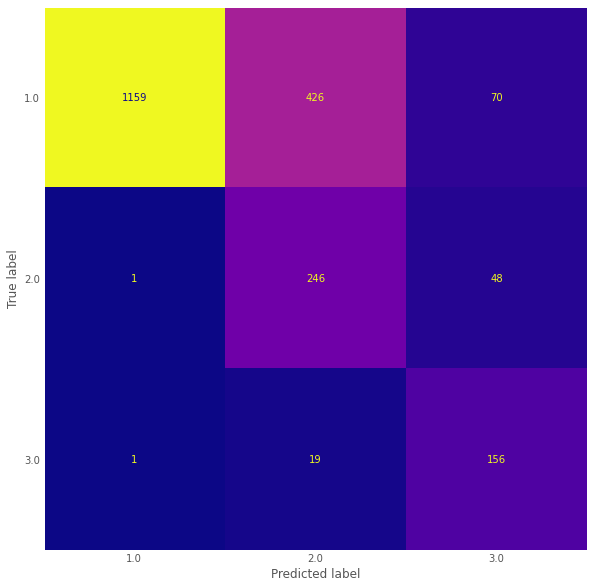

In [17]:
# matriz de confusión
conf_3_ver = confusion_matrix(y,y_3_pred_ver)

# plt.rcParams["figure.figsize"] = (15,15)
# grafico matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_3_ver, display_labels=gnb_3.classes_)
disp.plot(values_format='d', colorbar=False, cmap='plasma') 
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

Se puede apreciar que aplicando esa logica se consigu el efecto buscado de reducir el numero de casos predichos incorrectamente como sospechos pero se incrementa el numero de casos incorrectamente predichos como patologicos.
Como en el caso anterior de 2 clases podriamos encontrar otras relaciones mas correctas consultando con el personal medico que tiene experiencia en la practica.  

Vamos a comparar ahora las predicciones con Bayes Ingenuos contra las visualizaciones en Componentes Principales

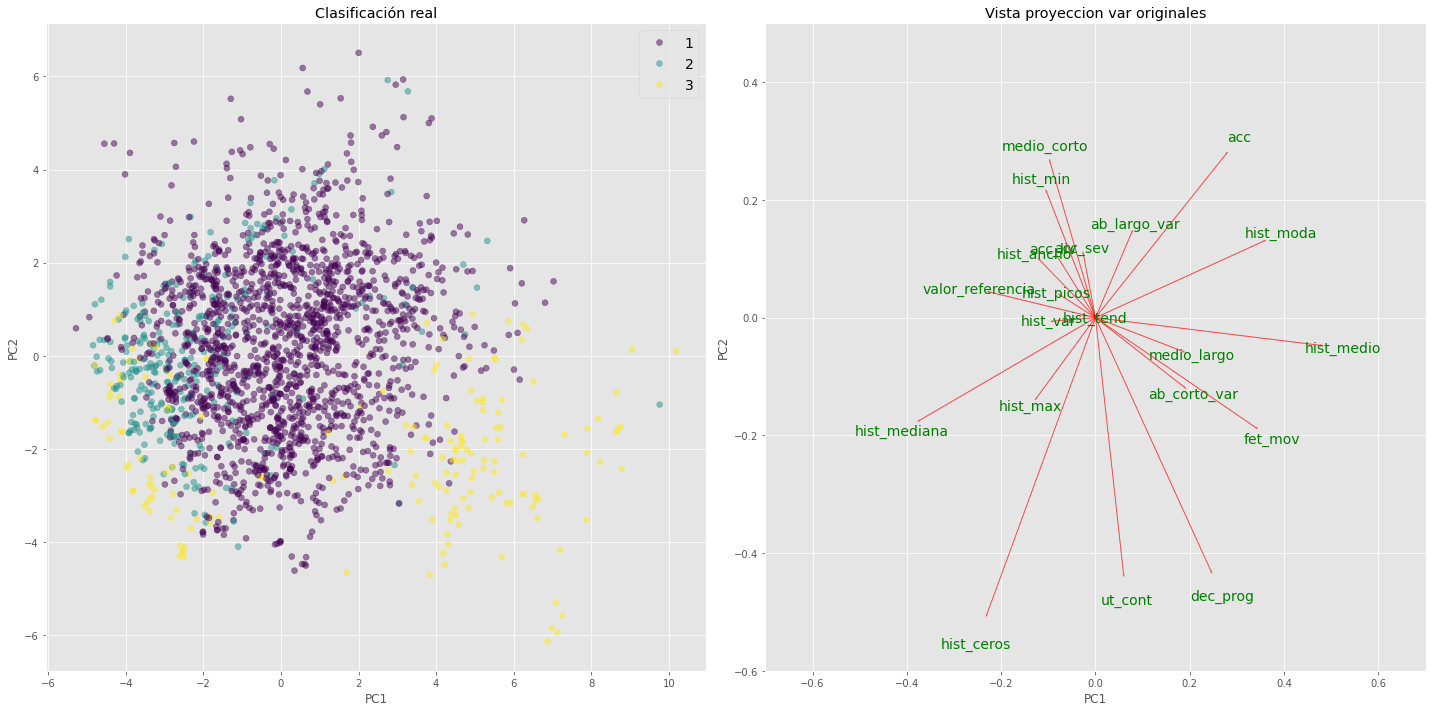

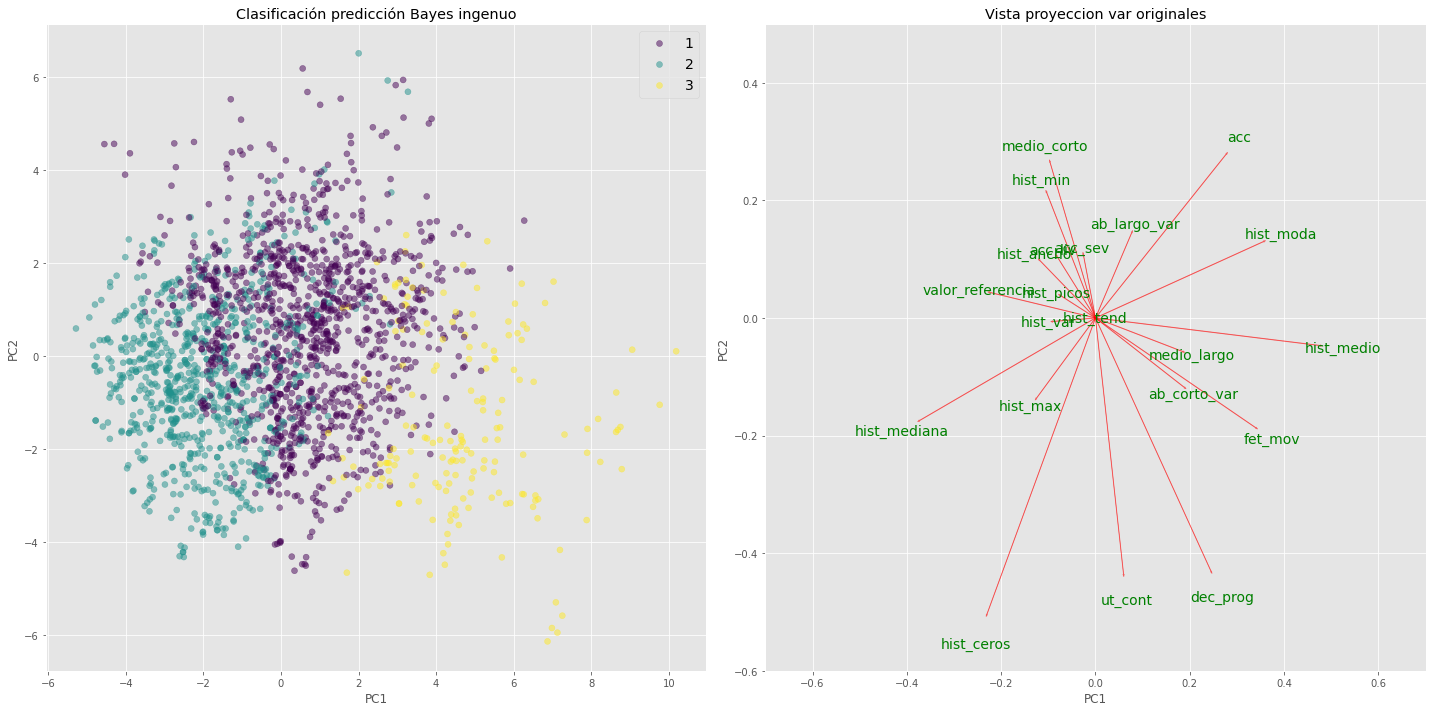

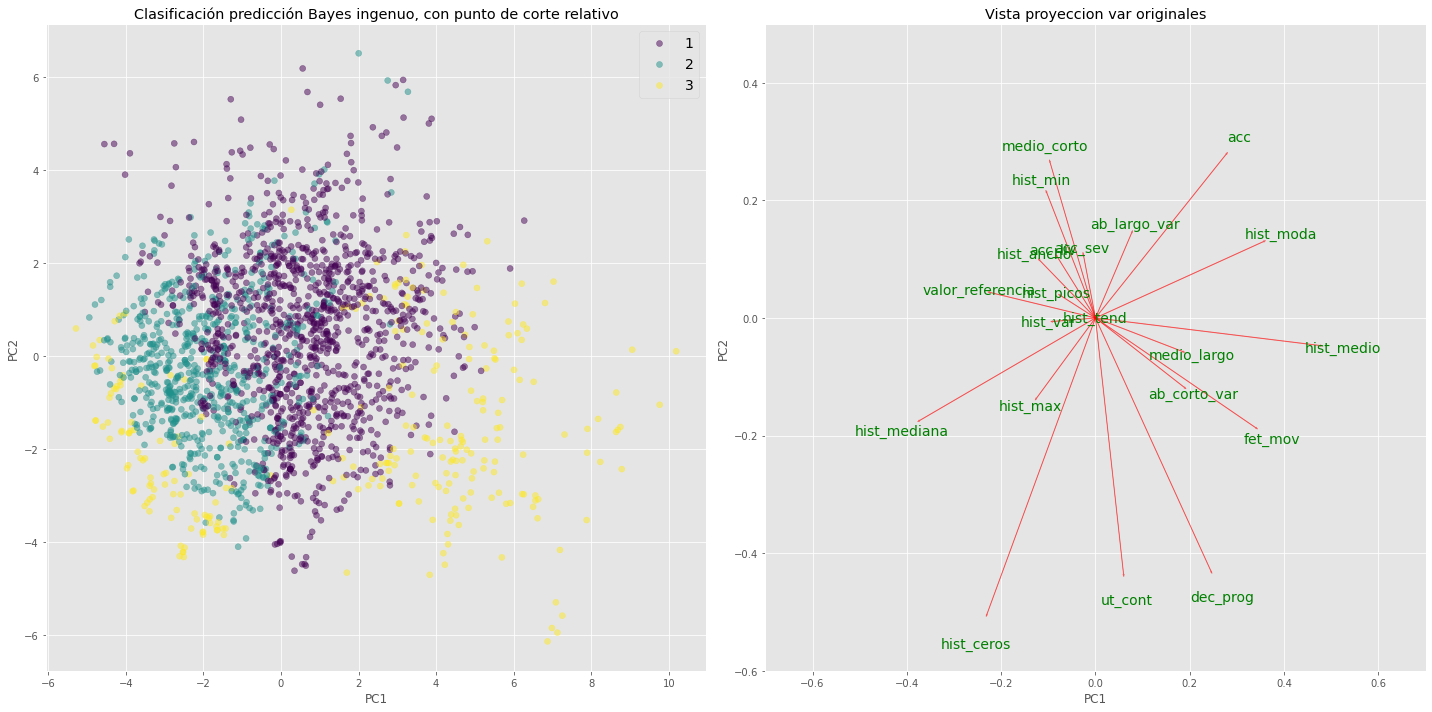

In [19]:
# Y vemos como se compara con los componentes principales
pca = PCA()
pca.fit(X)
x_new = pca.transform(X)


def myplot(score,coeff,clases,labels=None,titulo1='Vista PCA',titulo2='Vista proyeccion var originales'):
    # grafico 1 con el scatterplot
    # creo el primer subplot a la izquierda (Ver doc matplotlib - subplots)
    fig1 = plt.subplot(1, 2, 1)
    # Esto ya estaba
    x1 = score[:,0]
    x2 = score[:,1]
    n = coeff.shape[0]
    # El scatter en si mismo
    scatter = plt.scatter(x1, x2, c=clases, alpha=0.5)
    # El cuadrito con las clases del target
    plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], fontsize=14)
    # Los ejes
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    # La grilla
    #plt.grid()
    # que le ponga el titulo pasado a la funcion
    plt.title(titulo1)
    
    # grafico 2 con la proyeccion
    # creo el segundo subplot a la derecha
    fig2 = plt.subplot(1, 2, 2)
    # Definimos el rango de los ejes del grafico
    plt.axis([-0.7,0.7,-0.6,0.5])

    # Esto sigue igual que al original
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        # si no vienen los nombres de los campos
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center', fontsize=14)
        # si vienen los nombres de los campos
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, labels[i], color = 'g', ha = 'center', va = 'center', fontsize=14)
    # Los ejes
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    # la grilla
    #plt.grid()
    # el titulo del segundo grafico
    plt.title(titulo2)
    # Le doy una separacion para que no se junten los graficos
    plt.tight_layout()
    plt.show()       

#Grafico las primeras dos componentes principales para cada clasificación

#clasificación real
myplot(x_new[:,0:2], pca.components_, y, nombres,'Clasificación real')


#clasificación bayes ingenuo
myplot(x_new[:,0:2], pca.components_, y_3_pred, nombres, 'Clasificación predicción Bayes ingenuo')

#clasif. bayes ingenuo con punto de corte 0.7 para y=0
myplot(x_new[:,0:2], pca.components_, y_3_pred_ver, nombres, 'Clasificación predicción Bayes ingenuo, con punto de corte relativo')
# plt.xlabel("PC{}".format(1))
# plt.ylabel("PC{}".format(2))
# plt.title("Clasificación predicción Bayes ingenuo, con punto de corte 0.7 para y=0")
# plt.grid()
# plt.show()


No se nota diferencia en las proyecciones de las variables originales en las componentes principales. Y que la eleccion de un punto de corte relativo no mejora la separacion de las clases.  
Podemos decir que la clasificacion en tres clases nos da una mejor informacion sobre la condicion de los pacientes y que podemos elegir distintos tipos de tratamientos o mejores estudios con un detalle mas fino.